/var/folders/_c/jm66wb4d7gl570d8vx4_wpx00000gn/T/ipykernel_59636/2193264295.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(step_csv_file)


Pearson Correlation Coefficient: 0.27
P-value: 0.0005
Result: Reject the null hypothesis. There is a statistically significant correlation.


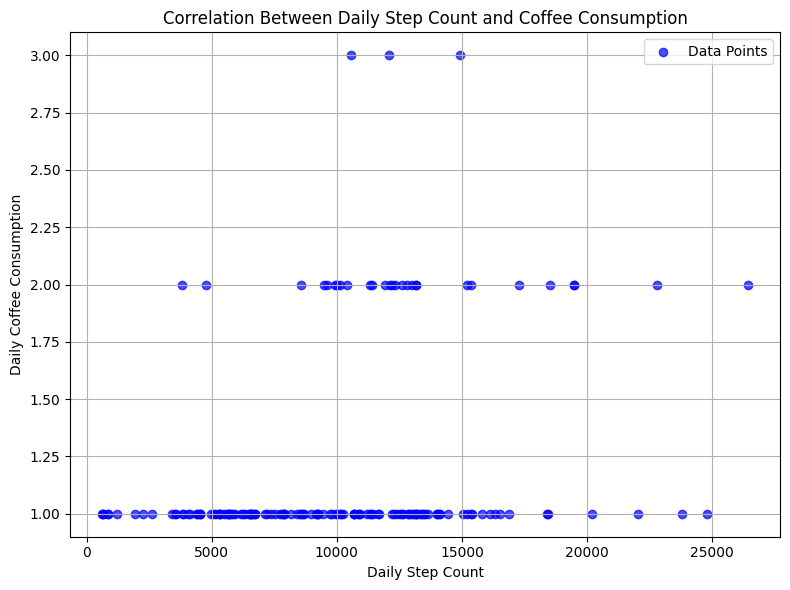

In [7]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def load_step_data(step_csv_file):
    try:
        data = pd.read_csv(step_csv_file)
        data = data[data['type'] == 'HKQuantityTypeIdentifierStepCount']  
        data['startDate'] = pd.to_datetime(data['startDate']) 
        
        data = data[data['startDate'] >= '2023-09-01']
        
        data['date'] = data['startDate'].dt.date
        data['value'] = pd.to_numeric(data['value'], errors='coerce')
        daily_steps = data.groupby('date')['value'].sum().reset_index()
        daily_steps.rename(columns={'value': 'DailyStepCount'}, inplace=True)
        return daily_steps
    except Exception as e:
        print("Error processing step count data:", e)
        return pd.DataFrame()

def load_coffee_data(coffee_csv_file):
    try:
        data = pd.read_csv(coffee_csv_file, sep=';', skiprows=1, names=['Date', 'Place', 'Amount'])
        data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce')
        data = data[data['Date'] != 'Date']
        data['Date'] = pd.to_datetime(data['Date'])
        
        daily_consumption = data.groupby('Date')['Amount'].sum().reset_index()
        daily_consumption.rename(columns={'Amount': 'DailyCoffeeConsumption'}, inplace=True)
        return daily_consumption
    except Exception as e:
        print("Error processing coffee data:", e)
        return pd.DataFrame()
    
def merge_data(step_data, coffee_data):
    try:
        step_data['date'] = pd.to_datetime(step_data['date'])
        coffee_data['Date'] = pd.to_datetime(coffee_data['Date'])
        
        combined_data = pd.merge(step_data, coffee_data, left_on='date', right_on='Date', how='inner')
        return combined_data[['date', 'DailyStepCount', 'DailyCoffeeConsumption']]
    except Exception as e:
        print("Error merging data:", e)
        return pd.DataFrame()


def test_correlation(combined_data):
    try:
        correlation, p_value = pearsonr(combined_data['DailyStepCount'], combined_data['DailyCoffeeConsumption'])
        print(f"Pearson Correlation Coefficient: {correlation:.2f}")
        print(f"P-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print("Result: Reject the null hypothesis. There is a statistically significant correlation.")
        else:
            print("Result: Fail to reject the null hypothesis. No statistically significant correlation.")
        
        return correlation, p_value
    except Exception as e:
        print("Error calculating correlation:", e)
        return None, None

def plot_correlation(combined_data):
    try:
        plt.figure(figsize=(8, 6))
        plt.scatter(combined_data['DailyStepCount'], combined_data['DailyCoffeeConsumption'], color='blue', alpha=0.7, label='Data Points')
        plt.xlabel('Daily Step Count')
        plt.ylabel('Daily Coffee Consumption')
        plt.title('Correlation Between Daily Step Count and Coffee Consumption')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Error plotting correlation:", e)

step_csv_file = '/Users/armanibrisim/Desktop/proje/apple_health_data.csv'
coffee_csv_file = '/Users/armanibrisim/Desktop/proje/spending_data1.csv'

step_data = load_step_data(step_csv_file)
coffee_data = load_coffee_data(coffee_csv_file)

if not step_data.empty and not coffee_data.empty:
    combined_data = merge_data(step_data, coffee_data)
    
    if not combined_data.empty:
        correlation, p_value = test_correlation(combined_data)
        plot_correlation(combined_data)
    else:
        print("Combined data is empty after merging. Check date formats or data content.")
else:
    print("Step or coffee data is empty. Check input files.")


Correlation between daily coffee consumption and exam days: 0.08
P-value: 0.3246
The correlation is not statistically significant.


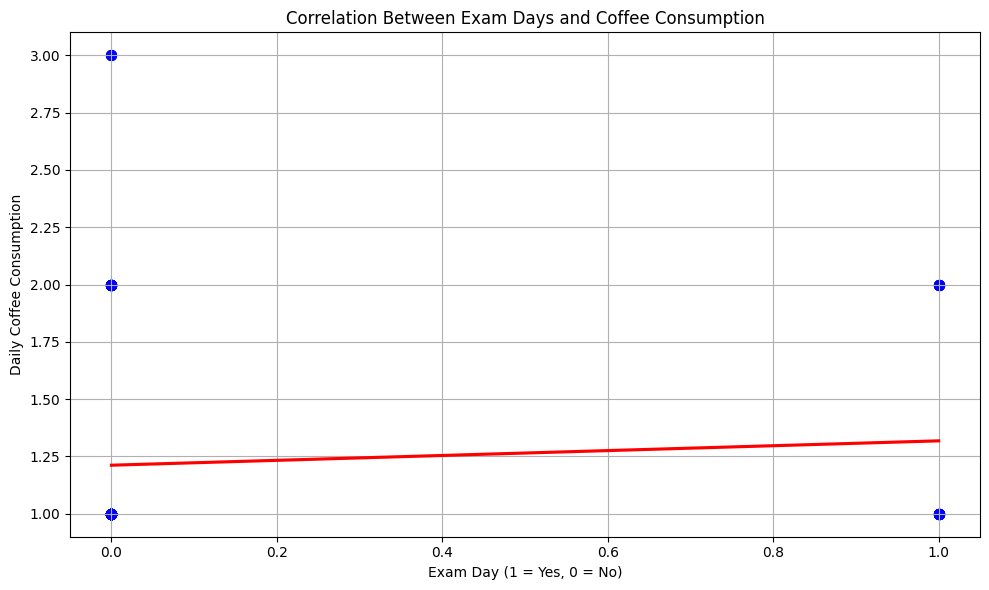

In [17]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

def load_coffee_data(coffee_csv_file):
    data = pd.read_csv(coffee_csv_file, sep=';', skiprows=1, names=['Date', 'Place', 'Amount'])
    data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce')
    data = data[data['Date'] != 'Date']
    data['Date'] = pd.to_datetime(data['Date'])
    
    daily_consumption = data.groupby('Date')['Amount'].sum().reset_index()
    daily_consumption.rename(columns={'Amount': 'DailyCoffeeConsumption'}, inplace=True)
    return daily_consumption

def load_exam_data(calendar_csv_file):
    calendar = pd.read_csv(calendar_csv_file)
    calendar['Start'] = pd.to_datetime(calendar['Start'])
    calendar['End'] = pd.to_datetime(calendar['End'])
    calendar['Event'] = calendar['Summary'].str.lower()
    calendar['IsExam'] = calendar['Event'].apply(lambda x: 1 if any(keyword in x for keyword in ['midterm', 'final', 'exam', 'quiz']) else 0)
    
    expanded_dates = []
    for _, row in calendar.iterrows():
        if row['IsExam'] == 1:
            date_range = pd.date_range(start=row['Start'], end=row['End'])
            expanded_dates.extend(date_range)
    
    exam_days = pd.DataFrame({'Date': pd.to_datetime(expanded_dates)}).drop_duplicates()
    exam_days['IsExamDay'] = 1
    return exam_days

def merge_data(coffee_data, exam_data):
    coffee_data['Date'] = coffee_data['Date'].dt.date
    exam_data['Date'] = exam_data['Date'].dt.date
    
    combined_data = pd.merge(coffee_data, exam_data, on='Date', how='left')
    combined_data['IsExamDay'] = combined_data['IsExamDay'].fillna(0)
    return combined_data

def analyze_correlation(combined_data):
    valid_data = combined_data.dropna(subset=['DailyCoffeeConsumption', 'IsExamDay'])
    if len(valid_data) == 0:
        print("No overlapping data between coffee consumption and exam dates.")
        return None, None
    correlation, p_value = pearsonr(valid_data['DailyCoffeeConsumption'], valid_data['IsExamDay'])
    print(f"Correlation between daily coffee consumption and exam days: {correlation:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")
    
    return correlation, p_value
def plot_correlation(combined_data):
    valid_data = combined_data.dropna(subset=['DailyCoffeeConsumption', 'IsExamDay'])
    if len(valid_data) == 0:
        print("No valid data to plot.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='IsExamDay',
        y='DailyCoffeeConsumption',
        data=valid_data,
        scatter_kws={'s': 50, 'color': 'blue'},
        line_kws={'color': 'red'},
        ci=None
    )
    plt.xlabel('Exam Day (1 = Yes, 0 = No)')
    plt.ylabel('Daily Coffee Consumption')
    plt.title('Correlation Between Exam Days and Coffee Consumption')
    plt.grid()
    plt.tight_layout()
    plt.show()

coffee_csv_file = 'spending_data1.csv'
calendar_csv_file = 'calendar_export.csv'

coffee_data = load_coffee_data(coffee_csv_file)
exam_data = load_exam_data(calendar_csv_file)

combined_data = merge_data(coffee_data, exam_data)

correlation, p_value = analyze_correlation(combined_data)

plot_correlation(combined_data)
